## Inside a Boiler - Slagging Prediction
#### https://opendata.edp.com/pages/challenges/#description

In [1]:
#%%
from imblearn.combine import SMOTETomek
import pandas as pd 
import numpy as np 
from numpy import sort, sqrt, argsort, inf
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold

from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, precision_recall_curve,confusion_matrix
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

In [2]:
data = pd.read_csv('..\\data\\boiler_unity_xxx3.csv',sep=';')

### Check: hay variables de temperatura que, según la literatura, podrían ser altamente informativas?

In [3]:
temperature_columns_mask = ['temperature' in x for x in data.columns]
data.columns[temperature_columns_mask]


Index([], dtype='object')

### Eliminamos variables altamente correladas entre sí

In [5]:
import pandas_profiling

#df_profile = pandas_profiling.ProfileReport(data)
df_profile.to_widgets()

### Check superficial de qué valores suelen encontrarse, para cierto atributo, en torno a las fechas previas a slag

In [19]:
Active_Power_mask = (data['Active_Power'] < 0.3) & (data['Active_Power'] > 0)
data[Active_Power_mask].SSTIMESTAMP.unique()

array(['14-04-xxx3 05:00:00', '14-04-xxx3 05:05:00',
       '14-04-xxx3 05:10:00', '14-04-xxx3 05:15:00',
       '14-04-xxx3 05:20:00', '14-04-xxx3 05:25:00',
       '14-04-xxx3 05:30:00', '14-04-xxx3 05:35:00',
       '14-04-xxx3 05:40:00', '14-04-xxx3 05:45:00',
       '15-04-xxx3 13:10:00', '15-04-xxx3 13:15:00',
       '15-04-xxx3 13:20:00', '20-04-xxx3 00:40:00',
       '20-04-xxx3 00:50:00', '20-04-xxx3 01:00:00',
       '20-04-xxx3 01:10:00', '20-04-xxx3 01:20:00',
       '20-04-xxx3 01:30:00', '20-04-xxx3 01:40:00',
       '20-04-xxx3 01:50:00', '20-04-xxx3 02:05:00',
       '20-04-xxx3 02:10:00', '20-04-xxx3 02:15:00',
       '20-04-xxx3 02:25:00', '20-04-xxx3 02:35:00',
       '20-04-xxx3 02:45:00', '20-04-xxx3 02:55:00',
       '20-04-xxx3 03:00:00', '20-04-xxx3 03:10:00',
       '20-04-xxx3 03:20:00', '20-04-xxx3 03:25:00',
       '20-04-xxx3 03:35:00', '20-04-xxx3 03:45:00',
       '20-04-xxx3 03:50:00', '20-04-xxx3 03:55:00',
       '20-04-xxx3 04:05:00', '20-04-xxx3 04:1

In [20]:
selected_colums_yisus = ['SSTIMESTAMP',
 'Active Power',
 'Boiler Furnace Pressure',
 'Boiler Outlet Pressure',
 'Coal Feeder #1',
 'Coal Feeder #5',
 'Cold Primary Air Control Damper Position @Coal Mill #1',
 'Cold Primary Air Control Damper Position @Coal Mill #2',
 'Cold Primary Air Control Damper Position @Coal Mill #3',
 'Cold Primary Air Control Damper Position @Coal Mill #4',
 'Cold Primary Air Control Damper Position @Coal Mill #5',
 'Hot Primary Air Control Damper Position @Coal Mill #1',
 'Hot Primary Air Control Damper Position @Coal Mill #2',
 'Hot Primary Air Control Damper Position @Coal Mill #3',
 'Hot Primary Air Control Damper Position @Coal Mill #4',
 'Hot Primary Air Control Damper Position @Coal Mill #5',
 'Dynamic Coal Classifier Rotational Speed Coal Mill #1',
 'Dynamic Coal Classifier Rotational Speed Coal Mill #2',
 'Dynamic Coal Classifier Rotational Speed Coal Mill #3',
 'Secondary Air Row #3 (Side 2)',
 'Secondary Air Row #5 (Side 2)',
 'Boosted Overfire Air (Side 1)',
 'Boosted Overfire Air (Side 2)',
 'Secondary Air Fan #1 Temperature 2',
 'Flue Gas Damper Position 1 (SH Side)',
 'Flue Gas Damper Position 2 (SH Side)',
 'Flue Gas Damper Position 1 (RH Side)',
 'Flue Gas Damper Position 2 (RH Side)',
 'Flue Gas Induced Draft Fan #1 Blade Pitch Angle',
 'Total Boiler Feedwater Flow',
 'Total Atemperator Feedwater Flow',
 'Main Steam First Desuperheater Control Valve position (Side 1)',
 'Main Steam First Desuperheater Control Valve position (Side 2)',
 'Main Steam Second Desuperheater Control Valve position (Side 1)',
 'Main Steam Second Desuperheater Control Valve position (Side 2)',
 'Main Steam Turbine Control Valve #B',
 'Main Steam Turbine Control Valve #D',
 'Emergency Reheated Steam Atemperation Valve Position',
 ]

In [27]:
'''
    En base a las correlaciones obtenidas en el profiling:
    - añado 'Boiler_Feedwater_Pressure'
    - elimino los cold primary air y me quedo con los hot primary air
    - añado 'Air Heater #1 Differential Pressure'
    - elimino 'Total_Boiler_Feedwater_Flow'
    - elimino los Flue gas damper position: por algo de experiencia, los valores que indican 
      posiciones de accionamientos no suelen informar de estados de procesos; además, el histograma de valores
      más anómalos (entre 0 y 10) no se dan en torno a las fechas de slag
    - 

'''

selected_colums_yirman = ['SSTIMESTAMP',
 'Active_Power',
 'Boiler_Feedwater_Pressure',
 'Boiler_Furnace_Pressure',
 'Boiler_Outlet_Pressure',
 'Coal_Feeder_#1',
 'Coal_Feeder_#5',
 'Dynamic_Coal_Classifier_Rotational_Speed_Coal_Mill_#1',
 'Dynamic_Coal_Classifier_Rotational_Speed_Coal_Mill_#2',
 'Dynamic_Coal_Classifier_Rotational_Speed_Coal_Mill_#3',
 'Secondary_Air_Row_#3_(Side_2)',
 'Secondary_Air_Row_#5_(Side_2)',
 'Boosted_Overfire_Air_(Side_1)',
 'Boosted_Overfire_Air_(Side_2)',
 'Secondary_Air_Fan_#1_Temperature_2',
 'Flue_Gas_Induced_Draft_Fan_#1_Blade_Pitch_Angle',
 'Total_Atemperator_Feedwater_Flow',
 'Main_Steam_First_Desuperheater_Control_Valve_position_(Side_1)',
 'Main_Steam_First_Desuperheater_Control_Valve_position_(Side_2)',
 'Main_Steam_Second_Desuperheater_Control_Valve_position_(Side_1)',
 'Main_Steam_Second_Desuperheater_Control_Valve_position_(Side_2)',
 'Main_Steam_Turbine_Control_Valve_#B',
 'Main_Steam_Turbine_Control_Valve_#D',
 'Air_Heater_#1_Differential_Pressure',
 'Reheated_Steam_Temperature_1_@Outlet']

data = data[selected_colums_yirman]

In [28]:
'''
data = data[selected_colums_yirman]
na_cols = [x for x in data.columns if x in data.columns[data.isnull().any()].tolist()]
for col in na_cols:
    data[col] = data[col].fillna(data[col].mean())
'''
#%%
def q10(x):
    return x.quantile(0.1)
def q20(x):
    return x.quantile(0.2)
def q30(x):
    return x.quantile(0.3)
def q40(x):
    return x.quantile(0.4)
def q50(x):
    return x.quantile(0.5)
def q60(x):
    return x.quantile(0.6)
def q70(x):
    return x.quantile(0.7)
def q80(x):
    return x.quantile(0.8)
def q90(x):
    return x.quantile(0.9)

### Para sampleo diario

In [500]:
'''
### Feature engineering: 
### 1.- en base a atributos estadísticos en sampleo diario
## ToDo:
### 2.- igual pero con otro sampling frequency
### 3.- añadiendo atributo de tendencias y/o estacionalidad
### 4.- TSFresh

unique_ID_values = data['ID'].unique()
unique_days = [x.split('-')[0] for x in unique_ID_values]
unique_months = [x.split('-')[1] for x in unique_ID_values]

tablon_final = pd.DataFrame({'ID': unique_ID_values, 'DAY': unique_days, 'MONTH': unique_months})
features = [x for x in data.columns if x not in ['TIME', 'HOUR', 'DAY', 'MONTH', 'ID']]
for col in features:
    #AÑADIR MEAN Y MEDIAN EXPONENTIALLY WEIGHTED
    prueba = data.groupby(['ID'])[col].agg(['count','mean','max','min','std','skew',q10]).reset_index(drop=True)
    prueba = prueba.add_prefix(col+'_')
    tablon_final = pd.concat([tablon_final, prueba],axis=1)
'''

"\n### Feature engineering: \n### 1.- en base a atributos estadísticos en sampleo diario\n## ToDo:\n### 2.- igual pero con otro sampling frequency\n### 3.- añadiendo atributo de tendencias y/o estacionalidad\n### 4.- TSFresh\n\nunique_ID_values = data['ID'].unique()\nunique_days = [x.split('-')[0] for x in unique_ID_values]\nunique_months = [x.split('-')[1] for x in unique_ID_values]\n\ntablon_final = pd.DataFrame({'ID': unique_ID_values, 'DAY': unique_days, 'MONTH': unique_months})\nfeatures = [x for x in data.columns if x not in ['TIME', 'HOUR', 'DAY', 'MONTH', 'ID']]\nfor col in features:\n    #AÑADIR MEAN Y MEDIAN EXPONENTIALLY WEIGHTED\n    prueba = data.groupby(['ID'])[col].agg(['count','mean','max','min','std','skew',q10]).reset_index(drop=True)\n    prueba = prueba.add_prefix(col+'_')\n    tablon_final = pd.concat([tablon_final, prueba],axis=1)\n"

### Para sampleo horario <font color='red'> (probar también con resampleo cada 4 horas por ejemplo) </font>

In [29]:

data['SSTIMESTAMP'][:3]

0    14-04-xxx3 05:00:00
1    14-04-xxx3 05:05:00
2    14-04-xxx3 05:10:00
Name: SSTIMESTAMP, dtype: object

### Creamos atributo ID con la combinación de mes+día+hora

In [30]:
datetime_values = data['SSTIMESTAMP']
hours_values = pd.Series([x.split(' ')[1].split(':')[0] for x in datetime_values]) 
days_values = pd.Series([x.split(' ')[0].split('-')[0] for x in datetime_values])
months_values = pd.Series([x.split(' ')[0].split('-')[1] for x in datetime_values])

frequency_sampling_ID = list([months_values[0]+'-'+days_values[0]+'-'+hours_values[0]])
for index in range(1, len(hours_values)):
    frequency_sampling_ID.append(months_values[index]+'-'+days_values[index]+'-'+hours_values[index])
data['ID_sampling'] = frequency_sampling_ID 

### Check: cada agrupación por ID_sampling debe contener 12 elementos (12 packs de 5 min por hora)

In [33]:
data.groupby(['ID_sampling'])['SSTIMESTAMP'].agg(['count'])

,count
ID_sampling,
01-01-00,12
01-01-01,12
01-01-02,12
01-01-03,12
01-01-04,12
...,...
12-31-19,12
12-31-20,12
12-31-21,12


In [34]:
data.head(5)

,SSTIMESTAMP,Active_Power,Boiler_Feedwater_Pressure,Boiler_Furnace_Pressure,Boiler_Outlet_Pressure,Coal_Feeder_#1,Coal_Feeder_#5,Dynamic_Coal_Classifier_Rotational_Speed_Coal_Mill_#1,Dynamic_Coal_Classifier_Rotational_Speed_Coal_Mill_#2,Dynamic_Coal_Classifier_Rotational_Speed_Coal_Mill_#3,...,Total_Atemperator_Feedwater_Flow,Main_Steam_First_Desuperheater_Control_Valve_position_(Side_1),Main_Steam_First_Desuperheater_Control_Valve_position_(Side_2),Main_Steam_Second_Desuperheater_Control_Valve_position_(Side_1),Main_Steam_Second_Desuperheater_Control_Valve_position_(Side_2),Main_Steam_Turbine_Control_Valve_#B,Main_Steam_Turbine_Control_Valve_#D,Air_Heater_#1_Differential_Pressure,Reheated_Steam_Temperature_1_@Outlet,ID_sampling
0,14-04-xxx3 05:00:00,0.165265,144.4336,-0.976562,-5.292969,17.79297,0.136719,129.834,120.7031,-0.048828,...,51.40245,3.588867,9.106445,101.2451,102.5635,26.94568,0.010643,2.984619,350.7541,04-14-05
1,14-04-xxx3 05:05:00,0.186440,149.9023,-1.152344,-4.941406,17.67578,0.136719,129.834,121.2891,-0.048828,...,54.26174,4.492188,10.815430,101.2695,102.5635,26.49239,0.010643,2.984619,358.3924,04-14-05
2,14-04-xxx3 05:10:00,0.210062,152.4414,-1.269531,-4.765625,17.82227,0.136719,129.834,122.0215,-0.048828,...,52.09245,4.418945,10.327150,101.5869,102.5635,25.98873,0.010643,3.118896,366.0051,04-14-05
3,14-04-xxx3 05:15:00,0.214660,151.2695,-0.976562,-4.550781,17.98828,0.136719,129.834,121.1914,-0.048828,...,47.57293,1.977539,6.811523,101.5381,102.5635,25.53543,0.010643,3.051758,375.2175,04-14-05
4,14-04-xxx3 05:20:00,0.215844,152.0508,-1.347656,-4.921875,17.61719,0.136719,129.834,122.2656,-0.048828,...,43.40686,0.488281,6.103516,101.2451,102.5635,25.28360,0.010643,3.253174,384.3479,04-14-05


### PLOTS

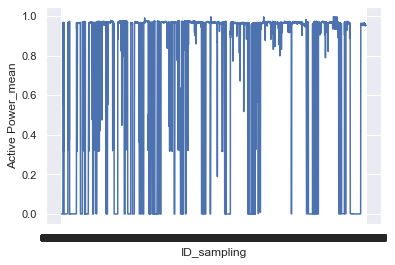

In [17]:
def plot_line_with_seaborn(dataset, x, y):
    import seaborn as sns; sns.set()
    import matplotlib.pyplot as plt

    ax = sns.lineplot(x=tablon_final.index, y="Active Power_mean", data=tablon_final)
    
plot_line_with_seaborn(dataset=tablon_final, x=tablon_final.index, y="Active Power_mean")

### Statistical features engineering

In [171]:
### Feature engineering: 
### 1.- en base a atributos estadísticos en sampleo horario
## ToDo:
### 2.- igual pero con otro sampling frequency
### 3.- añadiendo atributo de tendencias y/o estacionalidad
### 4.- TSFresh

tablon_final = pd.DataFrame({'ID_sampling': frequency_sampling_ID, 'HOUR': hours_values, 'DAY': days_values, 'MONTH': months_values})
tablon_final.drop_duplicates(subset='ID_sampling', keep='first', inplace=True)
tablon_final.set_index('ID_sampling', inplace=True)

features = [x for x in data.columns if x not in ['ID_sampling', 'HOUR', 'DAY', 'MONTH', 'SSTIMESTAMP']]

for col in features:
    #AÑADIR MEAN Y MEDIAN EXPONENTIALLY WEIGHTED
    data_hourly_grouped = data.groupby(['ID_sampling'])[col].agg(['count','mean','max','min','std','skew',q10]).reset_index(drop=True)
    data_hourly_grouped = data_hourly_grouped.add_prefix(col+'_')
    data_hourly_grouped.index = tablon_final.index
    tablon_final = pd.concat([tablon_final, data_hourly_grouped],axis=1)


In [172]:
tablon_final.MONTH = tablon_final.MONTH.astype('int32')
tablon_final.DAY = tablon_final.DAY.astype('int32')
tablon_final.HOUR = tablon_final.HOUR.astype('int32')

tablon_final.sort_values(by=['MONTH', 'DAY', 'HOUR'], ascending=[1, 1, 1], inplace=True)

tablon_final.tail()

,HOUR,DAY,MONTH,Active_Power_count,Active_Power_mean,Active_Power_max,Active_Power_min,Active_Power_std,Active_Power_skew,Active_Power_q10,...,Air_Heater_#1_Differential_Pressure_std,Air_Heater_#1_Differential_Pressure_skew,Air_Heater_#1_Differential_Pressure_q10,Reheated_Steam_Temperature_1_@Outlet_count,Reheated_Steam_Temperature_1_@Outlet_mean,Reheated_Steam_Temperature_1_@Outlet_max,Reheated_Steam_Temperature_1_@Outlet_min,Reheated_Steam_Temperature_1_@Outlet_std,Reheated_Steam_Temperature_1_@Outlet_skew,Reheated_Steam_Temperature_1_@Outlet_q10
ID_sampling,,,,,,,,,,,,,,,,,,,,,
12-31-19,19,31,12,12,0.952320,0.953785,0.950193,0.001114,-0.657970,0.950858,...,0.044355,-0.199619,9.436035,12,528.096175,528.5209,526.7057,0.606076,-1.331748,527.34985
12-31-20,20,31,12,12,0.953082,0.956220,0.951113,0.001545,0.374125,0.951216,...,0.017458,-3.356205,9.429932,12,529.387733,530.9990,528.5209,0.744423,0.817317,528.52090
12-31-21,21,31,12,12,0.953071,0.954170,0.951259,0.000944,-0.637840,0.951923,...,0.023900,2.109635,9.344482,12,530.318492,530.9990,529.8615,0.323224,0.109726,529.86150
12-31-22,22,31,12,12,0.952100,0.954699,0.950015,0.001456,0.363308,0.950471,...,0.030794,1.228296,9.387207,12,530.306983,532.3994,527.6744,1.686662,-0.211472,527.87925
12-31-23,23,31,12,12,0.953036,0.955259,0.949088,0.001961,-0.849123,0.950322,...,0.061496,-0.709394,9.264526,12,533.077825,533.4312,532.7877,0.315543,0.314680,532.78770


In [173]:
tablon_final[np.isnan(tablon_final['Active_Power_mean'])]
tablon_final

,HOUR,DAY,MONTH,Active_Power_count,Active_Power_mean,Active_Power_max,Active_Power_min,Active_Power_std,Active_Power_skew,Active_Power_q10,...,Air_Heater_#1_Differential_Pressure_std,Air_Heater_#1_Differential_Pressure_skew,Air_Heater_#1_Differential_Pressure_q10,Reheated_Steam_Temperature_1_@Outlet_count,Reheated_Steam_Temperature_1_@Outlet_mean,Reheated_Steam_Temperature_1_@Outlet_max,Reheated_Steam_Temperature_1_@Outlet_min,Reheated_Steam_Temperature_1_@Outlet_std,Reheated_Steam_Temperature_1_@Outlet_skew,Reheated_Steam_Temperature_1_@Outlet_q10
ID_sampling,,,,,,,,,,,,,,,,,,,,,
01-01-00,0,1,1,12,-0.000928,-0.000912,-0.000943,0.000010,0.000000,-0.000940,...,0.000000,0.000000,-0.158691,12,74.341773,74.78867,73.67287,0.316658,-1.246053e-01,74.25780
01-01-01,1,1,1,12,-0.000894,-0.000879,-0.000910,0.000010,0.000000,-0.000907,...,0.000000,0.000000,-0.158691,12,73.403030,73.67287,73.13319,0.281839,-9.078650e-14,73.13319
01-01-02,2,1,1,12,-0.000861,-0.000846,-0.000876,0.000010,0.000000,-0.000873,...,0.000000,0.000000,-0.158691,12,72.394597,72.59454,71.99471,0.295336,-8.124038e-01,71.99471
01-01-03,3,1,1,12,-0.000828,-0.000812,-0.000843,0.000010,0.000000,-0.000840,...,0.006010,0.812404,-0.158691,12,71.562462,71.99471,71.41838,0.260655,1.326650e+00,71.41838
01-01-04,4,1,1,12,-0.000800,-0.000790,-0.000810,0.000007,0.000000,-0.000808,...,0.000000,0.000000,-0.146484,12,70.612440,70.81923,70.19886,0.305449,-8.124038e-01,70.19886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12-31-19,19,31,12,12,0.952320,0.953785,0.950193,0.001114,-0.657970,0.950858,...,0.044355,-0.199619,9.436035,12,528.096175,528.52090,526.70570,0.606076,-1.331748e+00,527.34985
12-31-20,20,31,12,12,0.953082,0.956220,0.951113,0.001545,0.374125,0.951216,...,0.017458,-3.356205,9.429932,12,529.387733,530.99900,528.52090,0.744423,8.173169e-01,528.52090
12-31-21,21,31,12,12,0.953071,0.954170,0.951259,0.000944,-0.637840,0.951923,...,0.023900,2.109635,9.344482,12,530.318492,530.99900,529.86150,0.323224,1.097255e-01,529.86150


## Añadimos los días que preceden al efecto de slag

In [174]:
### El resto de días no nos preocupa, ya que caeríamos dentro de los falsos positivos 
warning_window_dates = ['03-10', '04-10', '04-10', '05-10', '06-10', '07-10', '08-10', '09-10', '10-10',
                        '11-10', '12-10', '13-10', '14-10', '15-10', '16-10', '17-10', '18-10', '19-10',
                        '20-10', '21-10', '22-10', '23-10', '24-10', '25-10']

In [175]:
# el slagging day registrado para el boiler 3 en el año 3 es: 3-11-XXX3
slag_day_reference = 34 #(31 días de octubre + 3 de noviembre como referencia)
tablon_final['DAYS_TILL_SLAG'] = 0 

for date in warning_window_dates: 
    warning_month = int(date.split('-')[1])
    warning_day = int(date.split('-')[0])
    
    tablon_final['DAYS_TILL_SLAG'] = \
        np.where(((tablon_final.MONTH==warning_month)&(tablon_final.DAY==warning_day)),slag_day_reference-warning_day,
                   tablon_final['DAYS_TILL_SLAG'])


In [176]:
tablon_final[tablon_final.DAYS_TILL_SLAG>0]

,HOUR,DAY,MONTH,Active_Power_count,Active_Power_mean,Active_Power_max,Active_Power_min,Active_Power_std,Active_Power_skew,Active_Power_q10,...,Air_Heater_#1_Differential_Pressure_skew,Air_Heater_#1_Differential_Pressure_q10,Reheated_Steam_Temperature_1_@Outlet_count,Reheated_Steam_Temperature_1_@Outlet_mean,Reheated_Steam_Temperature_1_@Outlet_max,Reheated_Steam_Temperature_1_@Outlet_min,Reheated_Steam_Temperature_1_@Outlet_std,Reheated_Steam_Temperature_1_@Outlet_skew,Reheated_Steam_Temperature_1_@Outlet_q10,DAYS_TILL_SLAG
ID_sampling,,,,,,,,,,,,,,,,,,,,,
10-03-00,0,3,10,12,0.960759,0.963718,0.957581,0.001668,0.028152,0.958921,...,-0.223636,8.269653,12,530.926917,531.6108,529.8294,0.626196,-0.287047,530.39030,31
10-03-01,1,3,10,12,0.960240,0.962587,0.955642,0.001828,-1.396219,0.958676,...,0.173601,8.336182,12,531.396350,532.0759,530.3903,0.645381,-0.847063,530.39030,31
10-03-02,2,3,10,12,0.961435,0.964225,0.959011,0.001415,0.530001,0.960384,...,1.736211,8.365478,12,531.533050,532.0759,530.2985,0.737678,-0.875594,530.35582,31
10-03-03,3,3,10,12,0.961182,0.963640,0.958146,0.001749,-0.205307,0.958998,...,-2.661198,8.442383,12,531.905767,532.1734,530.8717,0.513386,-1.675666,530.94105,31
10-03-04,4,3,10,12,0.960988,0.967245,0.954098,0.003565,-0.291933,0.956276,...,-0.818236,8.234253,12,530.985692,532.2979,528.5895,1.305420,-0.989066,529.13420,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10-25-19,19,25,10,12,-0.001418,-0.001388,-0.001448,0.000020,0.000000,-0.001442,...,3.464102,-0.207520,12,136.044658,137.2387,134.9138,0.798766,0.108282,134.97360,9
10-25-20,20,25,10,12,-0.001484,-0.001453,-0.001514,0.000020,0.000000,-0.001508,...,0.000000,-0.207520,12,133.273292,134.2472,132.0783,0.805236,-0.232327,132.12960,9
10-25-21,21,25,10,12,-0.001549,-0.001519,-0.001574,0.000019,0.000000,-0.001574,...,0.000000,-0.207520,12,130.537025,131.5358,129.1672,0.839172,-0.209696,129.69110,9


### Etiquetamos clases binarias. 

### Posteriormente, etiqutado multiclase para dar mayor relevancia en las predicciones de nuestros positivos (efecto slag) a los registros etiquetados como 4, luego 3... ya que nuestra hipótesis es que el efecto debe ser más evidente en días más próximos al efecto slag, y esto es más avanzados en nuestro warning window


In [177]:
tablon_final['TARGET'] = 0

mask_label = (tablon_final.DAYS_TILL_SLAG < 31)&(tablon_final.DAYS_TILL_SLAG >= 9)
mask_indexes = tablon_final[mask_label].index 
tablon_final.loc[mask_indexes, 'TARGET'] = 1
'''
mask_label = (tablon_final.DAYS_TILL_SLAG < 21)&(tablon_final.DAYS_TILL_SLAG > 8)
mask_indexes = tablon_final[mask_label].index 
tablon_final.loc[mask_indexes, 'TARGET'] = 2
'''

"\nmask_label = (tablon_final.DAYS_TILL_SLAG < 21)&(tablon_final.DAYS_TILL_SLAG > 8)\nmask_indexes = tablon_final[mask_label].index \ntablon_final.loc[mask_indexes, 'TARGET'] = 2\n"

In [178]:
tablon_final[tablon_final.TARGET>0][['MONTH', 'DAY', 'DAYS_TILL_SLAG', 'TARGET']]

,MONTH,DAY,DAYS_TILL_SLAG,TARGET
ID_sampling,,,,
10-04-00,10,4,30,1
10-04-01,10,4,30,1
10-04-02,10,4,30,1
10-04-03,10,4,30,1
10-04-04,10,4,30,1
...,...,...,...,...
10-25-19,10,25,9,1
10-25-20,10,25,9,1
10-25-21,10,25,9,1


### Construimos nuestro input attributes y el target

In [162]:
#inputs = [x for x in tablon_final.columns if x not in ['TARGET', 'DAYS_TILL_SLAG', 'HOUR', 'DAY', 'MONTH']]
inputs = [x for x in tablon_final.columns if x not in ['TARGET', 'HOUR', 'DAY', 'MONTH']]
X = tablon_final[inputs]
y = tablon_final['TARGET']

In [170]:
tablon_final[['DAYS_TILL_SLAG', 'Active_Power_mean']]

,DAYS_TILL_SLAG,Active_Power_mean
ID_sampling,,
01-01-00,0,-0.000928
01-01-01,0,-0.000894
01-01-02,0,-0.000861
01-01-03,0,-0.000828
01-01-04,0,-0.000800
...,...,...
12-31-19,0,0.952320
12-31-20,0,0.953082
12-31-21,0,0.953071


### Escalamos valores estandarizando: standard scaler

In [183]:
def scale_and_save_scaler(dataframe, features_to_scale, saving_path=False):
    try:
        import pandas as pd
        from sklearn.preprocessing import StandardScaler
        from joblib import dump

        #husillo m22
        standard_scaler = StandardScaler()
        standard_scaler.fit(dataframe[features_to_scale].values)
        scaled_dataframe_values = standard_scaler.transform(dataframe[features_to_scale].values)
        scaled_dataframe = pd.DataFrame(columns=features_to_scale, data=scaled_dataframe_values)
        
        features_no_to_scale = [x for x in dataframe.columns if x not in features_to_scale]
        final_scaled_df = pd.concat([dataframe[features_no_to_scale], dataframe[features_to_scale]], axis=1) 
        
        if saving_path:
            dump(standard_scaler, saving_path) 

        return final_scaled_df

    except Exception as exc:
        return exc
    
numeric_features = [x for x in tablon_final.columns if x not in ['TARGET', 'DAYS_TILL_SLAG', 'HOUR', 'DAY', 'MONTH']]
X_scaled = scale_and_save_scaler(X, features_to_scale = numeric_features)

In [187]:
X_scaled.drop(columns=['index'], inplace=True)
X_scaled[X_scaled.DAYS_TILL_SLAG>0]

,DAYS_TILL_SLAG,Active_Power_count,Active_Power_mean,Active_Power_max,Active_Power_min,Active_Power_std,Active_Power_skew,Active_Power_q10,Boiler_Feedwater_Pressure_count,Boiler_Feedwater_Pressure_mean,...,Air_Heater_#1_Differential_Pressure_std,Air_Heater_#1_Differential_Pressure_skew,Air_Heater_#1_Differential_Pressure_q10,Reheated_Steam_Temperature_1_@Outlet_count,Reheated_Steam_Temperature_1_@Outlet_mean,Reheated_Steam_Temperature_1_@Outlet_max,Reheated_Steam_Temperature_1_@Outlet_min,Reheated_Steam_Temperature_1_@Outlet_std,Reheated_Steam_Temperature_1_@Outlet_skew,Reheated_Steam_Temperature_1_@Outlet_q10
ID_sampling,,,,,,,,,,,,,,,,,,,,,
10-03-00,31,12,0.960759,0.963718,0.957581,0.001668,0.028152,0.958921,12,207.560192,...,0.072817,-0.223636,8.269653,12,530.926917,531.6108,529.8294,0.626196,-0.287047,530.39030
10-03-01,31,12,0.960240,0.962587,0.955642,0.001828,-1.396219,0.958676,12,207.438150,...,0.044914,0.173601,8.336182,12,531.396350,532.0759,530.3903,0.645381,-0.847063,530.39030
10-03-02,31,12,0.961435,0.964225,0.959011,0.001415,0.530001,0.960384,12,207.486958,...,0.088082,1.736211,8.365478,12,531.533050,532.0759,530.2985,0.737678,-0.875594,530.35582
10-03-03,31,12,0.961182,0.963640,0.958146,0.001749,-0.205307,0.958998,12,207.666008,...,0.087891,-2.661198,8.442383,12,531.905767,532.1734,530.8717,0.513386,-1.675666,530.94105
10-03-04,31,12,0.960988,0.967245,0.954098,0.003565,-0.291933,0.956276,12,207.861300,...,0.126212,-0.818236,8.234253,12,530.985692,532.2979,528.5895,1.305420,-0.989066,529.13420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10-25-19,9,12,-0.001418,-0.001388,-0.001448,0.000020,0.000000,-0.001442,12,-0.488281,...,0.017619,3.464102,-0.207520,12,136.044658,137.2387,134.9138,0.798766,0.108282,134.97360
10-25-20,9,12,-0.001484,-0.001453,-0.001514,0.000020,0.000000,-0.001508,12,-0.488281,...,0.000000,0.000000,-0.207520,12,133.273292,134.2472,132.0783,0.805236,-0.232327,132.12960
10-25-21,9,12,-0.001549,-0.001519,-0.001574,0.000019,0.000000,-0.001574,12,-0.488281,...,0.000000,0.000000,-0.207520,12,130.537025,131.5358,129.1672,0.839172,-0.209696,129.69110


### Interpolamos valores ausentes: método lineal para datos de sensores

In [188]:
def imputeMissingInterpolating(array_df, features_to_impute):
    import numpy as np
    for attr in features_to_impute:
        attribute_interpolated = array_df[attr].interpolate(method='linear', limit_direction='both')
        #print('nans length for {}: {}'.format(attr, len(attribute_interpolated[np.isnan(attribute_interpolated)])))
        assert len(attribute_interpolated[np.isnan(attribute_interpolated)]) == 0
        
        array_df[attr] = attribute_interpolated
    
    return array_df

X_scaled_interpolated = imputeMissingInterpolating(X_scaled, numeric_features)

In [190]:
X_scaled_interpolated[X_scaled.DAYS_TILL_SLAG>0]

,DAYS_TILL_SLAG,Active_Power_count,Active_Power_mean,Active_Power_max,Active_Power_min,Active_Power_std,Active_Power_skew,Active_Power_q10,Boiler_Feedwater_Pressure_count,Boiler_Feedwater_Pressure_mean,...,Air_Heater_#1_Differential_Pressure_std,Air_Heater_#1_Differential_Pressure_skew,Air_Heater_#1_Differential_Pressure_q10,Reheated_Steam_Temperature_1_@Outlet_count,Reheated_Steam_Temperature_1_@Outlet_mean,Reheated_Steam_Temperature_1_@Outlet_max,Reheated_Steam_Temperature_1_@Outlet_min,Reheated_Steam_Temperature_1_@Outlet_std,Reheated_Steam_Temperature_1_@Outlet_skew,Reheated_Steam_Temperature_1_@Outlet_q10
ID_sampling,,,,,,,,,,,,,,,,,,,,,
10-03-00,31,12,0.960759,0.963718,0.957581,0.001668,0.028152,0.958921,12,207.560192,...,0.072817,-0.223636,8.269653,12,530.926917,531.6108,529.8294,0.626196,-0.287047,530.39030
10-03-01,31,12,0.960240,0.962587,0.955642,0.001828,-1.396219,0.958676,12,207.438150,...,0.044914,0.173601,8.336182,12,531.396350,532.0759,530.3903,0.645381,-0.847063,530.39030
10-03-02,31,12,0.961435,0.964225,0.959011,0.001415,0.530001,0.960384,12,207.486958,...,0.088082,1.736211,8.365478,12,531.533050,532.0759,530.2985,0.737678,-0.875594,530.35582
10-03-03,31,12,0.961182,0.963640,0.958146,0.001749,-0.205307,0.958998,12,207.666008,...,0.087891,-2.661198,8.442383,12,531.905767,532.1734,530.8717,0.513386,-1.675666,530.94105
10-03-04,31,12,0.960988,0.967245,0.954098,0.003565,-0.291933,0.956276,12,207.861300,...,0.126212,-0.818236,8.234253,12,530.985692,532.2979,528.5895,1.305420,-0.989066,529.13420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10-25-19,9,12,-0.001418,-0.001388,-0.001448,0.000020,0.000000,-0.001442,12,-0.488281,...,0.017619,3.464102,-0.207520,12,136.044658,137.2387,134.9138,0.798766,0.108282,134.97360
10-25-20,9,12,-0.001484,-0.001453,-0.001514,0.000020,0.000000,-0.001508,12,-0.488281,...,0.000000,0.000000,-0.207520,12,133.273292,134.2472,132.0783,0.805236,-0.232327,132.12960
10-25-21,9,12,-0.001549,-0.001519,-0.001574,0.000019,0.000000,-0.001574,12,-0.488281,...,0.000000,0.000000,-0.207520,12,130.537025,131.5358,129.1672,0.839172,-0.209696,129.69110


In [191]:
### Stratified train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X_scaled_interpolated , y, test_size=0.20, stratify=y)


In [195]:
len(y_train[y_train==0])
y_test

ID_sampling
05-15-10    0
11-20-18    0
09-27-11    0
06-04-15    0
02-17-04    0
           ..
01-23-05    0
02-01-03    0
09-25-10    0
08-14-03    0
09-23-05    0
Name: TARGET, Length: 1757, dtype: int64

In [196]:
days_until_slag = X_test['DAYS_TILL_SLAG']
days_until_slag

ID_sampling
05-15-10    0
11-20-18    0
09-27-11    0
06-04-15    0
02-17-04    0
           ..
01-23-05    0
02-01-03    0
09-25-10    0
08-14-03    0
09-23-05    0
Name: DAYS_TILL_SLAG, Length: 1757, dtype: int64

### Esto nos hace ver la importancia de probar otro sampleo con el que tengamos más datos, a parte de probar el SMOTE para oversamplear <font color='red'> Probar también con el parámetro 'scale_pos_weight' de XGBOOST para el desbalanceo </font> 

In [199]:
### Automatic Oversampling: check el valor añadido de esto VS no hacerlo
smt_sample = SMOTETomek(sampling_strategy ="auto")

X_train_attributes = numeric_features #X_train.columns
X_test_attributes = numeric_features #X_test.columns

X_smt, y_smt = smt_sample.fit_sample(X_train[X_train_attributes], y_train)
y_smt = pd.Series(y_smt)
dataframe_stage_2 = pd.DataFrame(data=X_smt, columns=list(X_train_attributes))


In [200]:
len(y_smt[y_smt==0])

6604

### EDP cost function to evaluate our training

In [203]:
### EDP cost function version 1 (falta incluir el coste por FP fuera de warning window):
def return_true_positive_savings(days_until_slag, no_return_days=9, tp_repair_cost=350000):
    try:
        tp_savings = tp_repair_cost - ((30-days_until_slag)*(tp_repair_cost/(30-no_return_days)))
        
        return tp_savings

    except Exception as exc:
        return exc
'''
def return_edp_savings_function(model, X_values, y_true_values): 
    """
        True positives (TP) are slagging events that happened in one of the boilers, detected in the warning window 
        (6/12 to 30 days before the date that marks the event). The point of no-return depends on the intensity of the 
        slagging event: 12 days prior to high-intensity slagging events or 6 days prior to low-intensity slagging events. 
        If a slagging event is detected in the warning window but in the wrong boiler, it counts as a false positive. 
        True Positives are translated into savings, according to the following expression:

        False negatives (FN) are real slagging events that happened in one of the boilers that are not detected in the 
        warning window. False negatives are translated into repair and downtime costs.

        False positives (FP) are detections in a boiler where there is no slagging events in the next 30 days. False positives 
        are translated into unnecessary inspection costs.

        Check for the special cases
    """
    try:

        costs_dict = {'fp_cost': 19253, 'fn_cost': 350000}
        warning_window_min = 9  
        warning_window_min = 30
               
        model_y_predicted_values = model.predict(X_values)
        model_y_predicted_probas = model.predict_proba(X_values)
        
        final_y_predicted_values = list(model_y_predicted_values)
        preds_probas_df = pd.DataFrame(model_y_predicted_probas) 
        for row_index in (preds_probas_df.index):
            new_prediction = assign_prediction_to_probas(preds_probas_df.iloc[row_index])

            final_y_predicted_values[row_index] = new_prediction
        
        
        true_predicted_tuples = pd.DataFrame({'y_true': y_true_values, 'y_predicted': final_y_predicted_values, \
                                              'days_till_slag': days_until_slag})
        true_predicted_tuples = true_predicted_tuples.reset_index(drop=True)
        #true positives, false positives and false negatives number
        tp_savings = 0
        
        first_tp_detected = False

        while first_tp_detected:
            for index in true_predicted_tuples.index:
                if ((true_predicted_tuples.iloc[index]['y_true']>0)&(true_predicted_tuples.iloc[index]['y_predicted']>0)):
                    tp_savings += return_true_positive_savings(true_predicted_tuples.iloc[index]['days_till_slag'])
                break
            first_tp_detected = True
        
        fp_number = len(true_predicted_tuples[(true_predicted_tuples.y_true==0)&(true_predicted_tuples.y_predicted==1)])
        fn_number = len(true_predicted_tuples[(true_predicted_tuples.y_true==1)&(true_predicted_tuples.y_predicted==0)])

        final_cost =  ((costs_dict['fp_cost'])*fp_number) + ((costs_dict['fn_cost'])*fn_number) - tp_savings
        
        # maximize de savings (i,e, minimize the cost)
        if final_cost == 0:
            return 0

        return 1/final_cost

    except Exception as exc:
        return exc
'''
    
def return_edp_savings_function(model, X_values, y_true_values): 
    """
        True positives (TP) are slagging events that happened in one of the boilers, detected in the warning window 
        (6/12 to 30 days before the date that marks the event). The point of no-return depends on the intensity of the 
        slagging event: 12 days prior to high-intensity slagging events or 6 days prior to low-intensity slagging events. 
        If a slagging event is detected in the warning window but in the wrong boiler, it counts as a false positive. 
        True Positives are translated into savings, according to the following expression:

        False negatives (FN) are real slagging events that happened in one of the boilers that are not detected in the 
        warning window. False negatives are translated into repair and downtime costs.

        False positives (FP) are detections in a boiler where there is no slagging events in the next 30 days. False positives 
        are translated into unnecessary inspection costs.

        Check for the special cases
    """
    
    try:

        costs_dict = {'fp_cost': 19253, 'fn_cost': 350000}

        #true_predicted_tuples = pd.DataFrame({'y_true': y_true_values, 'y_predicted': y_predicted_values, 'days_till_slag': days_until_slag})
        y_predicted_values = model.predict(X_values)
        true_predicted_tuples = pd.DataFrame({'y_true': y_true_values, 'y_predicted': y_predicted_values, \
                                              'days_till_slag': days_until_slag.values})
        true_predicted_tuples = true_predicted_tuples.reset_index(drop=True)
        #true positives, false positives and false negatives number
        tp_savings = 0
        
        first_tp_detected = False

        while first_tp_detected:
            for index in true_predicted_tuples.index:
                if ((true_predicted_tuples.iloc[index]['y_true']==1)&(true_predicted_tuples.iloc[index]['y_predicted']==1)):
                    tp_savings += return_true_positive_savings(true_predicted_tuples.iloc[index]['days_till_slag'])
                break
            first_tp_detected = True
        
        fp_number = len(true_predicted_tuples[(true_predicted_tuples.y_true==0)&(true_predicted_tuples.y_predicted==1)])
        fn_number = len(true_predicted_tuples[(true_predicted_tuples.y_true==1)&(true_predicted_tuples.y_predicted==0)])

        final_savings = tp_savings - ((costs_dict['fp_cost'])*fp_number) - ((costs_dict['fn_cost'])*fn_number)

        return 'edp_savings', final_savings

    except Exception as exc:
        return exc
    

In [204]:
xgb = XGBClassifier(objective= 'binary:logistic') #'multi:softprob')
eval_set = [(X_test[X_test_attributes], y_test)]

xgb = xgb.fit(dataframe_stage_2,y_smt, eval_metric=return_edp_savings_function, #'auc', 
              verbose=True)
first_xgb_predictions = xgb.predict(X_test[X_test_attributes])
print('with eval_metric = {}'.format('auc'))
confusion_matrix(y_test, first_xgb_predictions)

with eval_metric = auc


array([[1628,   23],
       [   3,  103]], dtype=int64)

### Plot confusion matrix, fuente: http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/

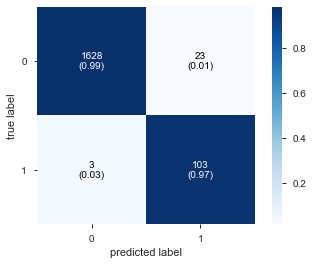

In [205]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, first_xgb_predictions),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

In [110]:
first_xgb_predictions_probas = xgb.predict_proba(X_test[X_test_attributes])
first_xgb_predictions_probas

array([[9.8414344e-01, 1.5856549e-02],
       [9.5957696e-01, 4.0423024e-02],
       [9.8889726e-01, 1.1102730e-02],
       ...,
       [9.9001741e-01, 9.9826045e-03],
       [9.9975449e-01, 2.4552675e-04],
       [7.6109767e-03, 9.9238902e-01]], dtype=float32)

In [111]:
first_xgb_predictions = xgb.predict(X_test[X_test_attributes])
first_xgb_predictions

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

### Probamos a ajustar las predicciones según diferentes thresolds para cada clase

#### <font color='green'> Para binario, la idea es: <p>
    - que reduzcamos el número de falsos positivos estableciendo un threshold de decisión más alto para los días más alejados del slag (entre 31 y 15?)
    - que reduzcamos falsos negativos, relajando el threshold de decisión a días próximos al slag (< 15?)  
     </font>

#### <font color='green'> Para multiclase, la idea es que reduzcamos el número de falsos negativos, por lo que hacemos que el threshold de decisión para la clase mayoritario ' no slag' sea más exigente, no sólo el máximo </font>


In [119]:
def assign_prediction_to_binary_probas(clf_prediction_proba, days_till_slag, proba_threshold=0.7, days_till_slag_threshold=15):
    import numpy as np
    import pandas as pd
    
    if days_till_slag > days_till_slag_threshold:
        if clf_prediction_proba[1] > proba_threshold:
            return 1
        else: return 0
    else:
        return np.max(0.5, clf_prediction_proba[1])
    

def assign_prediction_to_multiclass_probas(clf_prediction_probas):
    import numpy as np
    import pandas as pd
    
    preds_df = pd.DataFrame({'preds_probas': clf_prediction_probas, 'class': list(range(0, len(clf_prediction_probas)))})
    if preds_df['preds_probas'][0] < 0.6:
        selected_proba = np.max(clf_prediction_probas[1:])
        final_prediction = preds_df[preds_df['preds_probas']==selected_proba]['class']
    else:
        final_prediction = preds_df[preds_df['preds_probas']==np.max(clf_prediction_probas)]['class']
    
    return final_prediction.values[0]

In [123]:
#pd.Series(first_xgb_predictions_probas.reshape(len(first_xgb_predictions_probas), 3))

#first_xgb_predictions_probas[5]

#assign_prediction_to_binary_probas(first_xgb_predictions_probas[5], )

In [124]:
'''
new_predictions = list(first_xgb_predictions)
preds_probas_df = pd.DataFrame(first_xgb_predictions_probas) 

for row_index in (preds_probas_df.index):
    new_prediction = assign_prediction_to_probas(preds_probas_df.iloc[row_index])
                                                                                  
    new_predictions[row_index] = new_prediction
    
new_predictions
'''

'\nnew_predictions = list(first_xgb_predictions)\npreds_probas_df = pd.DataFrame(first_xgb_predictions_probas) \n\nfor row_index in (preds_probas_df.index):\n    new_prediction = assign_prediction_to_probas(preds_probas_df.iloc[row_index])\n                                                                                  \n    new_predictions[row_index] = new_prediction\n    \nnew_predictions\n'

In [135]:
return_edp_savings_function(xgb, dataframe_stage_2, y_smt)

ValueError('array length 13208 does not match index length 21991')

### Hemos definido nuestra función ahorro como la inversa del coste asociado a los errores de nuestras predicciones

In [207]:
### Hiperparam. con Bayesian optimization
from hyperopt import hp
from sklearn.model_selection import StratifiedKFold

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
def acc_model(params):
    clf = XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=10, shuffle=True)
    #lou_lr2 = LeaveOneOut()
    #return cross_val_score(clf, dataframe_stage_2, y_smt, cv =cv,n_jobs=10, scoring='recall').mean()
    #return cross_val_score(clf, dataframe_stage_2, y_smt, cv =cv,n_jobs=10, scoring=return_edp_savings_function).mean()
    return cross_val_score(clf, dataframe_stage_2, y_smt, cv =cv,n_jobs=10, scoring='roc_auc').mean()

    
param_space = {'max_depth' : hp.choice('max_depth', range(5, 30, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(20, 205, 5)),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)}

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=30, trials=trials)
#%%
print ('best:')
print (best)


new best:                                                                                                              
0.9999862397769966                                                                                                     
{'colsample_bytree': 0.9400000000000001, 'gamma': 0.29, 'learning_rate': 0.42, 'max_depth': 8, 'min_child_weight': 8.0, 'n_estimators': 50, 'subsample': 0.91}
new best:                                                                                                              
0.9999862397769966                                                                                                     
{'colsample_bytree': 0.64, 'gamma': 0.16, 'learning_rate': 0.45, 'max_depth': 8, 'min_child_weight': 7.0, 'n_estimators': 200, 'subsample': 0.14}
new best:                                                                                                              
0.9999862397769966                                                                             

### Reentrenamos y evaluamos con los best params

In [206]:
# %%
params=best
params['objective'] = 'multi:softprob'
from xgboost import XGBClassifier
xgb_last_clf = XGBClassifier(**params)

# %%
#clf = clf.fit(dataframe_stage_2,y_smt)
xgb_last_clf = xgb_last_clf.fit(dataframe_stage_2,y_smt, eval_metric=return_edp_cost_function, 
                                eval_set=eval_set, verbose=True)
                                
# %%
last_xgb_predictions = xgb_last_clf.predict(X_test[X_test_attributes])
confusion_matrix(y_test,last_xgb_predictions)

#%%[markdown]
### Edp cost:
last_xgb_edp_function_cost = return_edp_cost_function(xgb_last_clf, X_test[X_test_attributes], y_test)
print('EDP cost with edp cost evaluation metric: {}'.format(last_xgb_edp_function_cost))



EDP cost with edp cost evaluation metric: 0


In [207]:
confusion_matrix(y_test, last_xgb_predictions)

array([[31,  3,  1],
       [ 1,  0,  0],
       [ 1,  0,  0]], dtype=int64)

In [232]:
y_test

ID
11-01    0
31-07    0
10-04    0
12-07    0
17-10    2
12-09    0
22-08    0
05-10    1
10-09    0
15-09    0
10-03    0
06-04    0
11-05    0
15-02    0
13-07    0
30-01    0
14-11    0
21-06    0
16-01    0
29-03    0
12-11    0
20-09    0
08-07    0
10-08    0
01-09    0
09-04    0
24-02    0
08-01    0
15-01    0
20-04    0
05-08    0
18-11    0
07-04    0
29-12    0
04-02    0
29-05    0
28-09    0
Name: TARGET, dtype: int64

In [236]:
last_xgb_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0], dtype=int64)

In [208]:
xgb_last_clf.predict_proba(X_test[X_test_attributes])

array([[0.26344746, 0.24535228, 0.24661888, 0.24458137],
       [0.2637498 , 0.24644332, 0.24494481, 0.24486208],
       [0.2635918 , 0.24532743, 0.24535336, 0.2457274 ],
       [0.25593334, 0.24795568, 0.24798188, 0.24812908],
       [0.26175705, 0.2436198 , 0.24456994, 0.25005317],
       [0.26042417, 0.24810816, 0.24730046, 0.24416718],
       [0.2617016 , 0.24576122, 0.24957655, 0.24296057],
       [0.25975063, 0.24783362, 0.24980837, 0.24260738],
       [0.26015648, 0.24601988, 0.24805316, 0.24577044],
       [0.2508713 , 0.24805133, 0.25114548, 0.24993189],
       [0.2619209 , 0.24972512, 0.24518985, 0.24316415],
       [0.26329753, 0.2460207 , 0.24623959, 0.24444218],
       [0.26239395, 0.24379678, 0.24754994, 0.2462593 ],
       [0.25140944, 0.24726123, 0.24734673, 0.25398266],
       [0.25057477, 0.24785285, 0.25344682, 0.24812552],
       [0.2622953 , 0.2440502 , 0.25014275, 0.24351174],
       [0.2622719 , 0.24490313, 0.245072  , 0.24775295],
       [0.2575192 , 0.2460763 ,

In [ ]:
def assign_prediction_to_proba(clf_prediction_proba):
    preds_dict = {'preds_probas': clf_prediction_proba, 'class': list(range(0, len(clf_prediction_proba)))}
    if preds_dict['preds_probas'][0] < 0.6:
        selected_proba = np.max(clf_prediction_proba[1:])
        final_prediction = preds_dict[preds_dict['preds_probas']==selected_proba]['class']
    
    return prediction

